# Parametrically driven resonator

One of the most famous effects displaced by nonlinear oscillators is parametric resonance, where the frequency of the linear resonator is modulated in time
[Phys. Rev. E 94, 022201 (2016)](https://doi.org/10.1103/PhysRevE.94.022201). In the following we analyse this system, governed by the equations

$$\ddot{x}(t)+\gamma\dot{x}(t)+\Omega^2(1-\lambda\cos(2\omega t + \psi))x + \alpha x^3 +\eta x^2 \dot{x}+F_\text{d}(t)=0$$

where for completeness we also considered an external drive term $F_\text{d}(t)=F\cos(\omega t + \theta)$ and a nonlinear damping term $\eta x^2 \dot{x}$

To implement this system in Harmonic Balance, we first import the library

In [1]:
using HarmonicBalance

Subsequently, we type define parameters in the problem and the oscillating amplitude function $x(t)$ using the `variables` macro from `Symbolics.jl`

In [2]:
@variables ω₀ γ λ F η α ω t x(t)

natural_equation =
    d(d(x, t), t) +
    γ * d(x, t) +
    (ω₀^2 - λ * cos(2 * ω * t)) * x +
    α * x^3 +
    η * d(x, t) * x^2
forces = F * cos(ω * t)
diff_eq = DifferentialEquation(natural_equation + forces, x)

System of 1 differential equations
Variables:       x(t)
Harmonic ansatz: x(t) => ;   

Differential(t)(Differential(t)(x(t))) + F*cos(t*ω) + Differential(t)(x(t))*γ + x(t)*(-cos(2t*ω)*λ + ω₀^2) + (x(t)^3)*α + (x(t)^2)*Differential(t)(x(t))*η ~ 0


Note that an equation of the form
$$
m \ddot{x}+m \omega_{0}^{2}\left(1-\lambda \cos (2\omega t+\psi)\right) x+\gamma \dot{x}+\alpha x^{3}+\eta x^{2} \dot{x}=F \cos \omega t
$$
can be brought to dimensionless form by rescaling the units as described in [Phys. Rev. E 94, 022201 (2016)](https://doi.org/10.1103/PhysRevE.94.022201).

We are interested in studying the response of the oscillator to parametric driving and forcing. In particular, we focus on the first parametric resonance of the system, i.e. operating around twice the bare frequency of the undriven oscillator $\omega$ while the frequency of the external drive is also $\omega$. For this purpose, we consider a harmonic ansatz which contains a single frequency: $$x(t)\approx u\cos(\omega t)+v\sin(\omega t)$$.
In HarmonicBalance, we can do this via `add_harmonic` command:

In [3]:
add_harmonic!(diff_eq, x, ω);
nothing # hide

and replacing this by the time independent (averaged) equations of motion. This can be simply done by writing

In [4]:
harmonic_eq = get_harmonic_equations(diff_eq)

A set of 2 harmonic equations
Variables: u1(T), v1(T)
Parameters: ω, α, γ, λ, ω₀, F, η

Harmonic ansatz: 
x(t) = u1(T)*cos(ωt) + v1(T)*sin(ωt)

Harmonic equations:

F - (1//2)*u1(T)*λ + (2//1)*Differential(T)(v1(T))*ω + Differential(T)(u1(T))*γ - u1(T)*(ω^2) + u1(T)*(ω₀^2) + v1(T)*γ*ω + (3//4)*(u1(T)^3)*α + (3//4)*(u1(T)^2)*Differential(T)(u1(T))*η + (1//2)*u1(T)*Differential(T)(v1(T))*v1(T)*η + (3//4)*u1(T)*(v1(T)^2)*α + (1//4)*(v1(T)^2)*Differential(T)(u1(T))*η + (1//4)*(u1(T)^2)*v1(T)*η*ω + (1//4)*(v1(T)^3)*η*ω ~ 0

Differential(T)(v1(T))*γ + (1//2)*v1(T)*λ - (2//1)*Differential(T)(u1(T))*ω - u1(T)*γ*ω - v1(T)*(ω^2) + v1(T)*(ω₀^2) + (1//4)*(u1(T)^2)*Differential(T)(v1(T))*η + (3//4)*(u1(T)^2)*v1(T)*α + (1//2)*u1(T)*v1(T)*Differential(T)(u1(T))*η + (3//4)*Differential(T)(v1(T))*(v1(T)^2)*η + (3//4)*(v1(T)^3)*α - (1//4)*(u1(T)^3)*η*ω - (1//4)*u1(T)*(v1(T)^2)*η*ω ~ 0


The output of these equations are consistent with the result found in the literature. Now we are interested in the linear response spectrum, which we can obtain from the solutions to the averaged equations (rotating frame) as a function of the external drive, after fixing all other parameters in the system. A call to `get_steady_states` then retrieves all steadystates found along the sweep employing the homotopy continuation method, which occurs in a complex space (see the nice [HomotopyContinuation.jl docs](https://www.juliahomotopycontinuation.org))

## 1D parameters
We start with a `varied` set containing one parameter, $\omega$,

In [5]:
fixed = (ω₀ => 1.0, γ => 1e-2, λ => 5e-2, F => 1e-3, α => 1.0, η => 0.3)
varied = ω => range(0.9, 1.1, 100)

result = get_steady_states(harmonic_eq, varied, fixed)

A steady state result for 100 parameter points

Solution branches:   5
   of which real:    5
   of which stable:  3

Classes: stable, physical, Hopf


In `get_steady_states`, the default method `WarmUp()` initiates the homotopy in a generalised version of the harmonic equations, where parameters become random complex numbers. A parameter homotopy then follows to each of the frequency values $\omega$ in sweep. This offers speed-up, but requires to be tested in each scenario against the method `TotalDegree`, which initializes the homotopy in a total degree system (maximum number of roots), but needs to track significantly more homotopy paths and there is slower.

After solving the system, we can save the full output of the simulation and the model (e.g. symbolic expressions for the harmonic equations) into a file

HarmonicBalance.save("parametron_result.jld2", result);

During the execution of `get_steady_states`, different solution branches are classified by their proximity in complex space, with subsequent filtering of real (physically acceptable solutions). In addition, the stability properties of each steady state is assessed from the eigenvalues of the Jacobian matrix. All this information can be succinctly represented in a 1D plot via

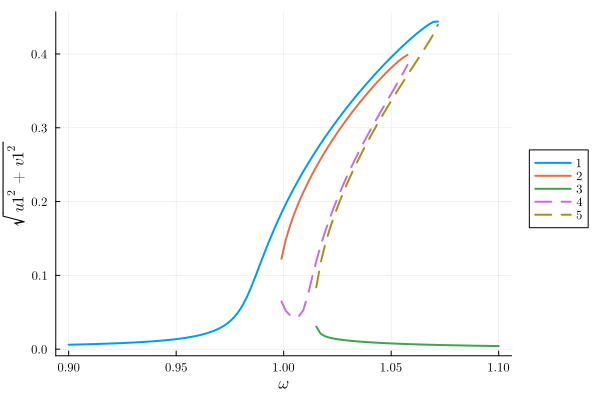

In [6]:
plot(result; x="ω", y="sqrt(u1^2 + v1^2)")

The user can also introduce custom classes based on parameter conditions via `classify_solutions!`. Plots can be overlaid and use keywords from `Plots`,\

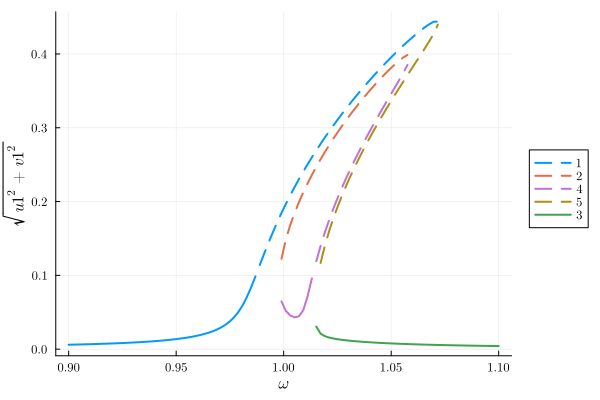

In [7]:
classify_solutions!(result, "sqrt(u1^2 + v1^2) > 0.1", "large")
plot(result, "sqrt(u1^2 + v1^2)"; class=["physical", "large"], style=:dash)
plot!(result, "sqrt(u1^2 + v1^2)"; not_class="large")

Alternatively, we may visualise all underlying solutions, including complex ones,

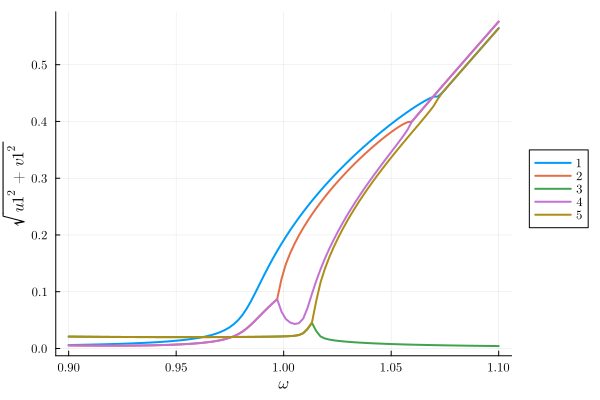

In [8]:
plot(result, "sqrt(u1^2 + v1^2)"; class="all")

## 2D parameters

The parametrically driven oscillator boasts a stability diagram called "Arnold's tongues" delineating zones where the oscillator is stable from those where it is exponentially unstable (if the nonlinearity was absence).  We can retrieve this diagram by calculating the steady states as a function of external detuning $\delta=\omega_L-\omega_0$ and the parametric drive strength $\lambda$.

To perform a 2D sweep over driving frequency $\omega$ and parametric drive strength $\lambda$, we keep `fixed` from before but include 2 variables in `varied`

In [9]:
fixed = (ω₀ => 1.0, γ => 1e-2, F => 1e-3, α => 1.0, η => 0.3)
varied = (ω => range(0.8, 1.2, 50), λ => range(0.001, 0.6, 50))
result_2D = get_steady_states(harmonic_eq, varied, fixed);

Now, we count the number of solutions for each point and represent the corresponding phase diagram in parameter space. This is done using `plot_phase_diagram`. Only counting stable solutions,

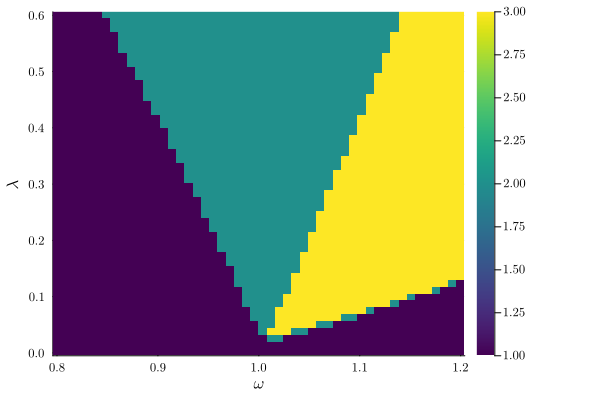

In [10]:
plot_phase_diagram(result_2D; class="stable")

In addition to phase diagrams, we can plot functions of the solution. The syntax is identical to 1D plotting. Let us overlay 2 branches into a single plot,

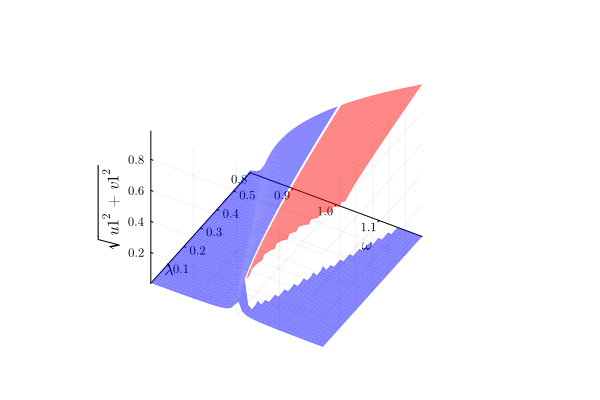

In [11]:
# overlay branches with different colors
plot(result_2D, "sqrt(u1^2 + v1^2)"; branch=1, class="stable", camera=(60, -40))
plot!(result_2D, "sqrt(u1^2 + v1^2)"; branch=2, class="stable", color=:red)

Note that solutions are ordered in parameter space according to their closest neighbors. Plots can again be limited to a given class (e.g stable solutions only) through the keyword argument `class`.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*